Tabla resumen:

         dataset  num_frames  mean_distance  spatial_std  spatial_range  \
0  wheel (robot)          11       1.019659     0.327081       0.974158   

   directional_std  
0          0.13272  


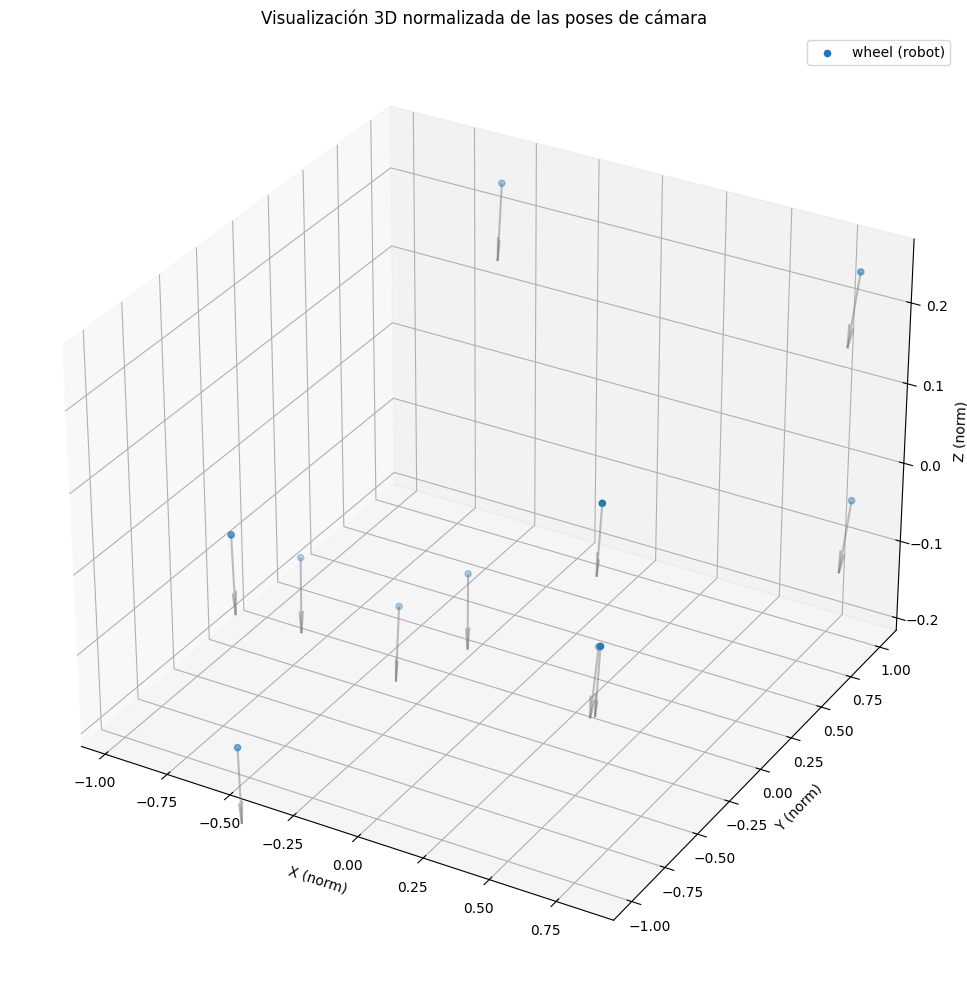

In [26]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Función para analizar las poses y normalizarlas a [-1, 1]
def analyze_poses(frames, label):
    positions = []
    forward_vectors = []

    for frame in frames:
        matrix = np.array(frame["transform_matrix"])
        position = matrix[:3, 3]
        forward = -matrix[:3, 2]
        positions.append(position)
        forward_vectors.append(forward)

    positions = np.array(positions)
    forward_vectors = np.array(forward_vectors)

    # Centrar y escalar posiciones a [-1, 1]
    center = positions.mean(axis=0)
    positions -= center
    max_abs = np.abs(positions).max()
    if max_abs > 0:
        positions /= max_abs

    pos_dists = np.linalg.norm(positions, axis=1)

    return {
        "label": label,
        "positions": positions,
        "forward_vectors": forward_vectors,
        "metrics": {
            "dataset": label,
            "num_frames": len(frames),
            "mean_distance": np.mean(pos_dists),
            "spatial_std": np.std(pos_dists),
            "spatial_range": np.max(pos_dists) - np.min(pos_dists),
            "directional_std": np.std(forward_vectors, axis=0).mean()
        }
    }

# Cargar archivos
with open("transforms.json") as f1:
    user_data = json.load(f1)

with open("../instant-ngp/data/nerf/fox/transforms.json") as f2:
    fox_data = json.load(f2)

with open("../nerf-pytorch/cache/nerf_synthetic/lego/transforms_train.json") as f3:
    lego_data = json.load(f3)

# Analizar datasets
datasets = [
    analyze_poses(user_data["frames"], "wheel (robot)"),
    # analyze_poses(fox_data["frames"], "fox (instant-ngp)"),
    # analyze_poses(lego_data["frames"], "lego (nerf-synthetic)")
]

# Crear tabla resumen
df_summary = pd.DataFrame([d["metrics"] for d in datasets])
print("Tabla resumen:\n")
print(df_summary)

# --- Visualización 3D normalizada (ya normalizadas en analyze_poses) ---
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for data in datasets:
    pos = data["positions"]
    fw = data["forward_vectors"]
    label = data["label"]

    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], label=label)
    for p, f in zip(pos, fw):
        ax.quiver(p[0], p[1], p[2], f[0], f[1], f[2], length=0.1, color='gray', alpha=0.5)

ax.set_title("Visualización 3D normalizada de las poses de cámara")
ax.set_xlabel("X (norm)")
ax.set_ylabel("Y (norm)")
ax.set_zlabel("Z (norm)")
ax.legend()
plt.tight_layout()
plt.show()